In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import wishart
from scipy.linalg import eigvals

from scipy.special import digamma, gamma
import seaborn as sns

In [7]:
def interpolation_matrices(Sigma_1, Sigma_2, Sigma_3, Sigma_4):

    """Provides an array with the matrices given by a regression model."""  
    """The regression starts with Sigma_1 and then goes to Sigma_2 and Sigma_3 and ends in Sigma_4."""
        
    # Define time intervals for interpolation
    t_1 = np.linspace(-1, 0, 200)
    t_1 = t_1[:, None, None]
    t_2 = np.linspace(0, 1, 200)
    t_2 = t_2[:, None, None]
    t_3 = np.linspace(1, 2, 200)
    t_3 = t_3[:, None, None]

    # Interpolate between the matrices
    Sigma_t1 = - t_1 * Sigma_1 + (1 + t_1) * Sigma_2
    Sigma_t2 = (1-t_2) * Sigma_2 + t_2 * Sigma_3
    Sigma_t3 =  (2-t_3) * Sigma_3 + (t_3 - 1) * Sigma_4

    # Concatenate the interpolated matrices
    return np.concatenate([Sigma_t1, Sigma_t2, Sigma_t3])

def generate_random_spd_matrix(q_array, limits_unif = 5, seed = 1):
    """
    Generate a list of random symmetric positive definite (SPD) matrices.
    
    Parameters:
        q_array (list of int): A list of integers specifying the dimensions of the SPD matrices.
        seed (int): A seed for the random number generator to ensure reproducibility.
    
    Returns:
        list of np.ndarray: A list of SPD matrices of the specified dimensions.
    """
    np.random.RandomState(seed)
    
    q_array = np.array(q_array, dtype = int)
    # Ensure the matrices are symmetric positive definite
    mat = [(np.random.rand(q_array[i], q_array[i])-1/2)*limits_unif for i in range(len(q_array))]
    return [np.dot(mat[i], mat[i].T) for i in range(len(q_array))]

def is_spd(matrix):
    """Check if a matrix is symmetric positive definite."""
    if np.allclose(matrix, matrix.T):
        try:
            np.linalg.cholesky(matrix)
            return True
        except np.linalg.LinAlgError:
            return False
    return False

def log_cholesky_distance(S1, S2):
    """Computes the log-Cholesky distance between two SPD matrices."""
    # Compute Cholesky decompositions
    R1 = np.linalg.cholesky(S1)
    R2 = np.linalg.cholesky(S2)
    
    # Compute differences in lower triangular and diagonal parts
    lower_diff = np.tril(R1, -1) - np.tril(R2, -1)
    diag_diff = np.diag(np.log(np.diag(R1)) - np.log(np.diag(R2)))
    
    # Compute Frobenius norms
    lower_norm = np.linalg.norm(lower_diff, ord='fro')**2
    diag_norm = np.linalg.norm(diag_diff, ord='fro')**2
    
    # Return the log-Cholesky distance
    return np.sqrt(lower_norm + diag_norm)


def affine_invariant(S1, S2):
    """
    Computes the affine-invariant Riemannian metric (AIRM) between two SPD matrices S1 and S2.

    Parameters:
        S1 (ndarray): Symmetric positive definite matrix of shape (n, n).
        S2 (ndarray): Symmetric positive definite matrix of shape (n, n).

    Returns:
        float: The affine-invariant Riemannian metric distance between S1 and S2.
    """
    # Compute the matrix solving S1^{-1} S2
    inv_S1_S2 = np.linalg.solve(S1, S2)
    
    # Compute the eigenvalues of the matrix
    eigenvalues = eigvals(inv_S1_S2)
    
    # Compute the log of eigenvalues and sum of their squares
    log_eigenvalues = np.log(eigenvalues.real)  # Ensure real part is taken
    distance = np.sqrt(np.sum(log_eigenvalues**2))
    
    return distance


In [3]:
## Calculate different options for the Fréchet mean, in order to compare with our candidate

def extrinsic_mean(Sigma, d):
    return d * Sigma 

def frechet_mean_ai(Sigma, d):
    """Calculates the Fréchet mean from a Wishart distribution for the affine-invariant metric."""
    # Compute the digamma term
    q = Sigma.shape[0]
    digamma_term = (1 / q) * sum([digamma((d - i + 1) / 2) for i in range(1, q + 1)])
    # Return the Fréchet mean
    return 2 * np.exp(digamma_term) * Sigma

def frechet_mean_lc(Sigma, d):
    """Calculates the Fréchet mean from a Wishart distribution for the log-Cholesky metric."""
    # Cholesky factor of Sigma
    L = np.linalg.cholesky(Sigma)

    # Cholesky factor of the Fréchet mean (T)
    q = L.shape[0]

    # Create index arrays for upper and lower triangular parts
    i, j = np.tril_indices(q, -1)

    # Compute diagonal elements
    diag_indices = np.arange(q)
    T_diag = L[diag_indices, diag_indices] * np.sqrt(2) * np.exp(0.5 * digamma((d - diag_indices) / 2))

    # Compute lower triangular elements (excluding diagonal)
    T_lower = L[i, j] * np.sqrt(2) * gamma((d - j + 1) / 2) / gamma((d - j) / 2)

    # Assign results to T
    T = np.zeros_like(L)
    T[diag_indices, diag_indices] = T_diag
    T[i, j] = T_lower
    # Return the Fréchet mean
    return T @ T.T
    # The mean of the chi distribution with k degrees of freedom is given by:
    # mean = sqrt(2) * Gamma((k + 1) / 2) / Gamma(k / 2)

In [16]:
def simulate_frechet_loss(d_array, Sigma_array, matrices, n_samples=10000):
    """ Simulate the Fréchet loss function for multiple (d, q) combinations.
    
    Args:
        d_array (list or np.array): Array of degrees of freedom for the Wishart distribution.
        q_array (list or np.array): Array of dimensions of SPD matrices.
        n_samples (int): Number of samples from the Wishart distribution.
    
    Returns:
        None: Plots the normalized Fréchet loss function for all (d, q) combinations.
    """
    sns.set_style("whitegrid")  # "white","dark","darkgrid","ticks"
    fig = plt.figure(facecolor="white", figsize=(7, 7))
    ax = fig.add_subplot(111)
    d_array = np.array(d_array, dtype=int)
    

    k = 0 
    for Sigma in Sigma_array:
        for d in d_array:
            
            q = Sigma.shape[0]
            np.random.seed(1)

            if d < q: 
                continue
            else:
                # Assign color to current combination
                # Control
                print(f"Simulating for d={d}, q={q}")
                samples = wishart.rvs(df=d, scale=Sigma, size=n_samples)

                # Compute distances log-Cholesky and affine-invariant
                
                distances_LC = np.array([
                    [log_cholesky_distance(matrix, Y) for Y in samples]
                    for matrix in matrices[k]
                ])
                
                distances_AI = np.array([
                    [affine_invariant(matrix, Y) for Y in samples]
                    for matrix in matrices[k]
                ])

                fm_lc = frechet_mean_lc(Sigma, d)
                functional_fm_lc = np.mean (
                    np.array([
                    log_cholesky_distance(fm_lc, Y)**2 for Y in samples
                ])
                )

                fm_ai = frechet_mean_ai(Sigma, d)
                functional_fm_ai = np.mean(
                    np.array([
                    affine_invariant(fm_ai, Y)**2 for Y in samples
                    ])
                )


                # Compute Fréchet loss
                normalized_loss_LC = (np.mean(distances_LC**2, axis=1) - functional_fm_lc) / functional_fm_lc 
                normalized_loss_AI = (np.mean(distances_AI**2, axis=1) - functional_fm_ai) / functional_fm_ai

                t_array = np.linspace(-1,2,600)

                #Plot the normalized losses
                if len(Sigma_array) == 1:
                    label1 = f"LC, d={d}"
                    label2 = f"AI, d={d}"
                elif len(d_array) == 1:
                    label1 = f"LC, q={q}, $\Sigma_{k+1}$"
                    label2 = f"AI, q={q}, $\Sigma_{k+1}$"
                else:
                    label1 = f"LC, d={d}, q={q}, $\Sigma_{k+1}$"
                    label2 = f"AI, d={d}, q={q}, $\Sigma_{k+1}$"
                linestyles = ['-', '--', '-.', ':']
                ax.plot(t_array, normalized_loss_LC, label=label1, color='red', linestyle=linestyles[k % len(linestyles)])
                ax.plot(t_array, normalized_loss_AI, label=label2, color='blue', linestyle=linestyles[k % len(linestyles)])
                k += 1        
            # Finalize the plot

    ax.set_xticks(ticks=[-1, 0, 1, 2], labels=[r"$\boldsymbol{M}_{\mathrm{Ext}}$", r"$\boldsymbol{M}_{\mathrm{AI}}$", r"$\boldsymbol{M}_{\mathrm{LC}}$", r"$\boldsymbol{M}_{\mathrm{Ext}}$"])
    ax.tick_params(labelsize=17)
    ax.set_xlabel(r"$\boldsymbol{M}(t)$", fontsize=17)
    ax.set_ylabel("Normalized Fréchet Loss", fontsize=17)
    ax.legend(loc='upper center', ncol=2, fontsize=14)
    #     plt.title(f"Normalized Fréchet Loss Function for d={d} and different $\Sigma$")
    # elif len(Sigma_array) == 1:
    #     plt.title(f"Normalized Fréchet Loss Function for a fixed $\Sigma$ and multiple d combinations")
    # else:
    #     plt.title(f"Normalized Fréchet Loss Function")
    ax.grid(True)
    fig.tight_layout()
    if len(d_array) == 1:
        fig.savefig('q' + str(q) +  '_d'  + str(d) + '_different_sigmas.pdf', bbox_inches='tight', format='pdf', transparent=True)
    else:
        fig.savefig('q' + str(q) +  '_different_d_one_sigma.pdf', bbox_inches='tight', format='pdf', transparent=True)
    plt.show()

In [10]:
def c_simulate_frechet_loss(d_array, Sigma_array, matrices, n_samples=10000):
    """ Simulate the Fréchet loss function for multiple (d, q) combinations.
    
    Args:
        d_array (list or np.array): Array of degrees of freedom for the Wishart distribution.
        q_array (list or np.array): Array of dimensions of SPD matrices.
        n_samples (int): Number of samples from the Wishart distribution.
    
    Returns:
        None: Plots the normalized Fréchet loss function for all (d, q) combinations.
    """

    d_array = np.array(d_array, dtype=int)
    plt.figure(figsize=(10, 6)) 

    k = 0 
    for Sigma in Sigma_array:
        for d in d_array:
            
            q = Sigma.shape[0]
            np.random.seed(1)

            if d < q: 
                continue
            else:
                # Assign color to current combination
                # Control
                print(f"Simulating for d={d}, q={q}")
                samples = wishart.rvs(df=d, scale=Sigma, size=n_samples)

                # Compute distances log-Cholesky and affine-invariant
                
                distances_LC = np.array([
                    [log_cholesky_distance(matrix, Y) for Y in samples]
                    for matrix in matrices
                ])
                
                distances_AI = np.array([
                    [affine_invariant(matrix, Y) for Y in samples]
                    for matrix in matrices
                ])

                fm_lc = frechet_mean_lc(Sigma, d)
                print('Fréchet mean, LC: ', fm_lc)
                functional_fm_lc = np.mean (
                    np.array([
                    log_cholesky_distance(fm_lc, Y)**2 for Y in samples
                ])
                )

                fm_ai = frechet_mean_ai(Sigma, d)
                print('Fréchet mean, AI: ', fm_ai)
                functional_fm_ai = np.mean(
                    np.array([
                    affine_invariant(fm_ai, Y)**2 for Y in samples
                    ])
                )


                # Compute Fréchet loss
                loss_LC = np.mean(distances_LC**2, axis=1)  
                loss_AI = np.mean(distances_AI**2, axis=1) 
                t_array = np.linspace(matrices[0][0][0], matrices[-1][0][0], 600)

                #Plot the normalized losses
                if len(Sigma_array) == 1:
                    label1 = f"LC, d={d}"
                    label2 = f"AI, d={d}"
                elif len(d_array) == 1:
                    label1 = f"LC, q={q}, $\Sigma_{k+1}$"
                    label2 = f"AI, q={q}, $\Sigma_{k+1}$"
                else:
                    label1 = f"LC, d={d}, q={q}, $\Sigma_{k+1}$"
                    label2 = f"AI, d={d}, q={q}, $\Sigma_{k+1}$"
                linestyles = ['-', '--', '-.', ':']
                plt.plot(t_array, loss_LC, label=label1, color='red', linestyle=linestyles[k % len(linestyles)])
                plt.plot(t_array, loss_AI, label=label2, color='blue', linestyle=linestyles[k % len(linestyles)])
                k += 1
        
            # Finalize the plot
    plt.xlabel("t")
    plt.ylabel("Normalized Loss")
    plt.hlines(functional_fm_lc, t_array[0], t_array[-1], color='red', linestyle='--', label = 'Functional at Fréchet Mean (LC)')
    plt.hlines(functional_fm_ai, t_array[0], t_array[-1], color='blue', linestyle='--', label = 'Functional at Fréchet Mean (AI)')
    if len(d_array) == 1:
        plt.title(f"Normalized Fréchet Loss Function for d={d}, $\Sigma(t) = t \Sigma$")
    else:
        plt.title(f"Normalized Fréchet Loss Function")
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
d_array = [5, 15, 25]  
d1_array = [5]
d2_array = [15]
d3_array = [25]
q1_array = [2]   
q2_array = [6]  
q3_array = [10] 

list_sigmas = generate_random_spd_matrix(q_array = np.array([2, 2, 6, 6, 10, 10]), seed = 1)
list_interp = []
for i in range(len(list_sigmas)):
    for j in range(len(d_array)):
        if d_array[j] >= list_sigmas[i].shape[0]:
            print(d_array[j],list_sigmas[i].shape[0])
            list_interp += [interpolation_matrices(extrinsic_mean(np.array(list_sigmas[i]), d=d_array[j]), frechet_mean_ai(np.array(list_sigmas[i]), d=d_array[j]), frechet_mean_lc(np.array(list_sigmas[i]), d=d_array[j]), extrinsic_mean(np.array(list_sigmas[i]), d=d_array[j])) ]

5 2
15 2
25 2
5 2
15 2
25 2
15 6
25 6
15 6
25 6
15 10
25 10
15 10
25 10


Simulating for d=15, q=2
Simulating for d=15, q=2


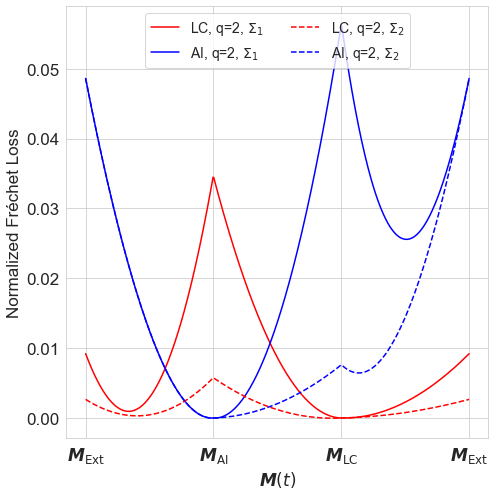

Simulating for d=15, q=6
Simulating for d=15, q=6


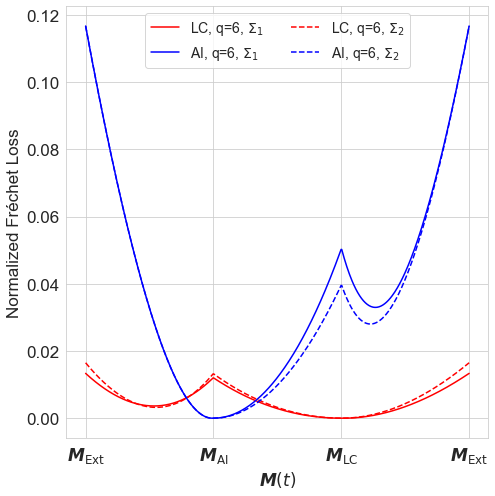

In [18]:
interp_d_5_q_2 = [list_interp[i] for i in [0,3]]
interp_d_15_q_2 = [list_interp[i] for i in [1, 4]]
interp_d_15_q_6 = [list_interp[i] for i in [6, 8]]
interp_d_15_q_10 = [list_interp[i] for i in [10, 12]]
interp_d_25_q_2 = [list_interp[i] for i in [2, 5]]
interp_d_25_q_6 = [list_interp[i] for i in [7, 9]]
interp_d_25_q_10 = [list_interp[i] for i in [11, 13]]

sigmas_q_2 = [list_sigmas[i] for i in [0, 1]]
sigmas_q_6 = [list_sigmas[i] for i in [2, 3]]
sigmas_q_10 = [list_sigmas[i] for i in [4, 5]]

#simulate_frechet_loss(d_array = d1_array, Sigma_array = sigmas_q_2, matrices = interp_d_5_q_2, n_samples = 10000)
simulate_frechet_loss(d_array = d2_array, Sigma_array = sigmas_q_2, matrices = interp_d_15_q_2, n_samples = 25000)
simulate_frechet_loss(d_array = d2_array, Sigma_array = sigmas_q_6, matrices = interp_d_15_q_6, n_samples = 25000)
#simulate_frechet_loss(d_array = d2_array, Sigma_array = sigmas_q_10, matrices = interp_d_15_q_10, n_samples = 10000)
#simulate_frechet_loss(d_array = d3_array, Sigma_array = sigmas_q_2, matrices = interp_d_25_q_2, n_samples = 10000)
#simulate_frechet_loss(d_array = d3_array, Sigma_array = sigmas_q_6, matrices = interp_d_25_q_6, n_samples = 10000)
#simulate_frechet_loss(d_array = d3_array, Sigma_array = sigmas_q_10, matrices = interp_d_25_q_10, n_samples = 10000)

Simulating for d=15, q=6
Simulating for d=25, q=6


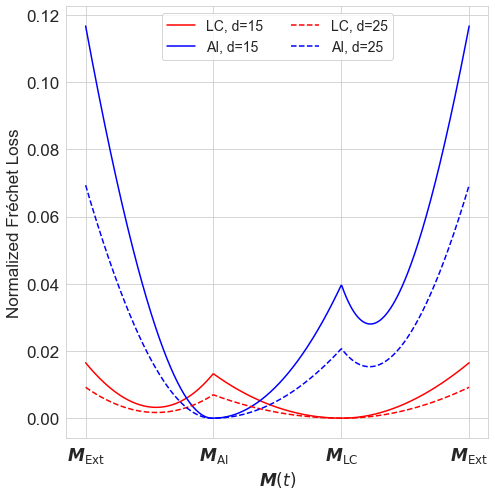

In [19]:
interp_sigma_1_q_2 = [list_interp[i] for i in [0,1,2]]
interp_sigma_2_q_2 = [list_interp[i] for i in [3,4,5]]
interp_sigma_1_q_6 = [list_interp[i] for i in [6, 7]]
interp_sigma_2_q_6 = [list_interp[i] for i in [8, 9]]
interp_sigma_1_q_10 = [list_interp[i] for i in [10, 11]]
interp_sigma_2_q_10 = [list_interp[i] for i in [12, 13]]


#simulate_frechet_loss(d_array = d_array, Sigma_array = np.array([sigmas_q_2[0]]), matrices = interp_sigma_1_q_2, n_samples = 10000)
#simulate_frechet_loss(d_array = d_array, Sigma_array = np.array([sigmas_q_2[1]]), matrices = interp_sigma_2_q_2, n_samples = 10000)
#simulate_frechet_loss(d_array = d_array, Sigma_array = np.array([sigmas_q_6[0]]), matrices = interp_sigma_1_q_6, n_samples = 10000)
simulate_frechet_loss(d_array = d_array, Sigma_array = np.array([sigmas_q_6[1]]), matrices = interp_sigma_2_q_6, n_samples = 25000)
#simulate_frechet_loss(d_array = d_array, Sigma_array = np.array([sigmas_q_10[0]]), matrices = interp_sigma_1_q_10, n_samples = 10000)
#simulate_frechet_loss(d_array = d_array, Sigma_array = np.array([sigmas_q_10[1]]), matrices = interp_sigma_2_q_10, n_samples = 10000)

### Check that the Log-cholesy Fréchet mean is not the identity matrix times a constant.

In [127]:
sigmas = generate_random_spd_matrix(q_array = np.array([2, 3]), seed = 1)
sigmas_q_2 = [np.eye(2)]
sigmas_q_3 = [np.eye(3)]
sigmas_q_2.append(sigmas[0])
sigmas_q_3.append(sigmas[1])

 Scale matrix Sigma: [[1. 0.]
 [0. 1.]]
Simulating for d=3, q=2
Fréchet mean, LC:  [[2.07432781 0.        ]
 [0.         1.12291897]]
Fréchet mean, AI:  [[1.52620511 0.        ]
 [0.         1.52620511]]


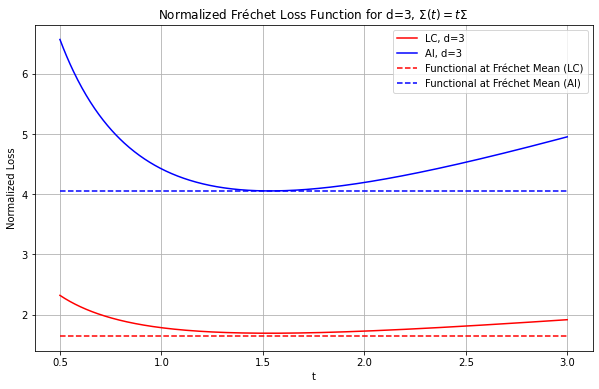

 Scale matrix Sigma: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Simulating for d=3, q=3
Fréchet mean, LC:  [[2.07432781 0.         0.        ]
 [0.         1.12291897 0.        ]
 [0.         0.         0.28072974]]
Fréchet mean, AI:  [[0.86797006 0.         0.        ]
 [0.         0.86797006 0.        ]
 [0.         0.         0.86797006]]


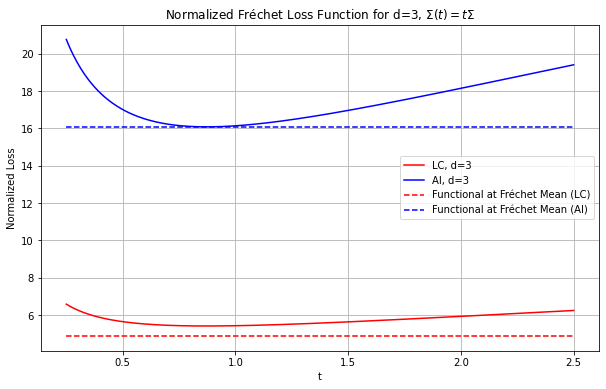

In [193]:
c1_array= np.linspace(.5, 3, 600)
c2_array= np.linspace(.25, 2.5, 600)
d1_array = [3]
c_id_q_2 = c1_array[:, None, None] * sigmas_q_2[0]
c_id_q_3 = c2_array[:, None, None] * sigmas_q_3[0]

c_simulate_frechet_loss(d_array = d1_array, Sigma_array = np.array([sigmas_q_2[0]]), matrices = c_id_q_2, n_samples = 10000)
c_simulate_frechet_loss(d_array = d1_array, Sigma_array = np.array([sigmas_q_3[0]]), matrices = c_id_q_3, n_samples = 10000)

 Scale matrix Sigma: [[1. 0.]
 [0. 1.]]
Simulating for d=5, q=2
Fréchet mean, LC:  [[4.04023889 0.        ]
 [0.         3.05241022]]
Fréchet mean, AI:  [[3.51176117 0.        ]
 [0.         3.51176117]]


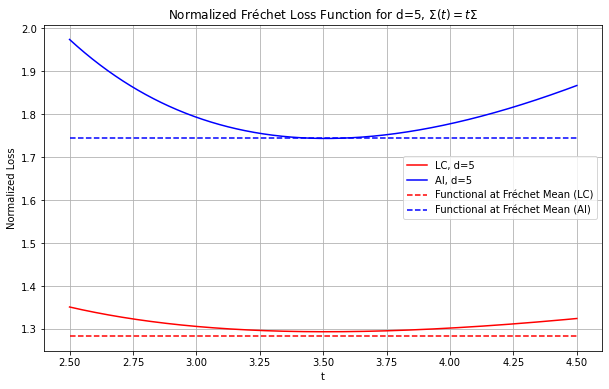

 Scale matrix Sigma: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Simulating for d=5, q=3
Fréchet mean, LC:  [[4.04023889 0.         0.        ]
 [0.         3.05241022 0.        ]
 [0.         0.         2.07432781]]
Fréchet mean, AI:  [[2.94651809 0.         0.        ]
 [0.         2.94651809 0.        ]
 [0.         0.         2.94651809]]


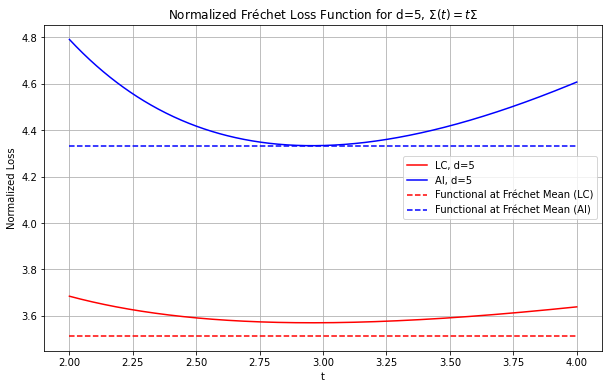

In [194]:
c1_array= np.linspace(2.5, 4.5, 600)
c2_array= np.linspace(2, 4, 600)
d2_array = [5]
c_id_q_2 = c1_array[:, None, None] * sigmas_q_2[0]
c_id_q_3 = c2_array[:, None, None] * sigmas_q_3[0]

c_simulate_frechet_loss(d_array = d2_array, Sigma_array = np.array([sigmas_q_2[0]]), matrices = c_id_q_2, n_samples = 10000)
c_simulate_frechet_loss(d_array = d2_array, Sigma_array = np.array([sigmas_q_3[0]]), matrices = c_id_q_3, n_samples = 10000)

 Scale matrix Sigma: [[ 0.22171292 -0.00828587]
 [-0.00828587  1.1558322 ]]
Simulating for d=3, q=2
Fréchet mean, LC:  [[ 0.45990528 -0.01904352]
 [-0.01904352  1.29834672]]
Fréchet mean, AI:  [[ 0.33837939 -0.01264594]
 [-0.01264594  1.76403701]]


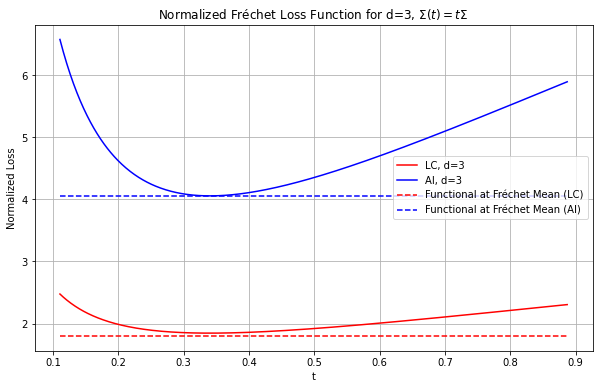

 Scale matrix Sigma: [[ 1.55760751  0.3378413   0.18304923]
 [ 0.3378413   0.14406073 -0.07245334]
 [ 0.18304923 -0.07245334  0.51273705]]
Simulating for d=3, q=3
Fréchet mean, LC:  [[ 3.23098857  0.77646431  0.42070403]
 [ 0.77646431  0.26608269 -0.04785321]
 [ 0.42070403 -0.04785321  0.42193959]]
Fréchet mean, AI:  [[ 1.35195668  0.29323614  0.15888126]
 [ 0.29323614  0.1250404  -0.06288733]
 [ 0.15888126 -0.06288733  0.44504041]]


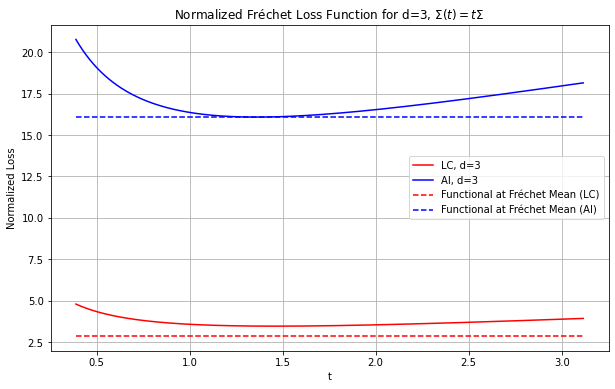

In [180]:
c1_array= np.linspace(0.5, 4, 600)
c2_array= np.linspace(0.25, 2, 600)
d1_array = [3]
c_id_q_2 = c1_array[:, None, None] * sigmas_q_2[1]
c_id_q_3 = c2_array[:, None, None] * sigmas_q_3[1]

c_simulate_frechet_loss(d_array = d1_array, Sigma_array = np.array([sigmas_q_2[1]]), matrices = c_id_q_2, n_samples = 10000)
c_simulate_frechet_loss(d_array = d1_array, Sigma_array = np.array([sigmas_q_3[1]]), matrices = c_id_q_3, n_samples = 10000)

 Scale matrix Sigma: [[ 0.22171292 -0.00828587]
 [-0.00828587  1.1558322 ]]
Simulating for d=5, q=2
Fréchet mean, LC:  [[ 0.89577316 -0.03543649]
 [-0.03543649  3.52853067]]
Fréchet mean, AI:  [[ 0.77860282 -0.02909801]
 [-0.02909801  4.05900664]]


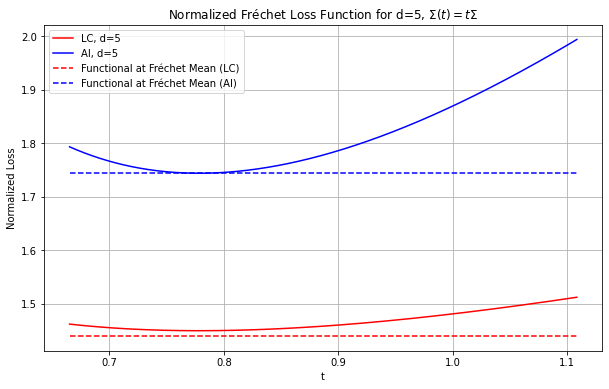

 Scale matrix Sigma: [[ 1.55760751  0.3378413   0.18304923]
 [ 0.3378413   0.14406073 -0.07245334]
 [ 0.18304923 -0.07245334  0.51273705]]
Simulating for d=5, q=3
Fréchet mean, LC:  [[ 6.29310643  1.44485765  0.78285302]
 [ 1.44485765  0.54779132 -0.18864203]
 [ 0.78285302 -0.18864203  1.37579899]]
Fréchet mean, AI:  [[ 4.58951869  0.99545551  0.53935788]
 [ 0.99545551  0.42447754 -0.21348507]
 [ 0.53935788 -0.21348507  1.51078899]]


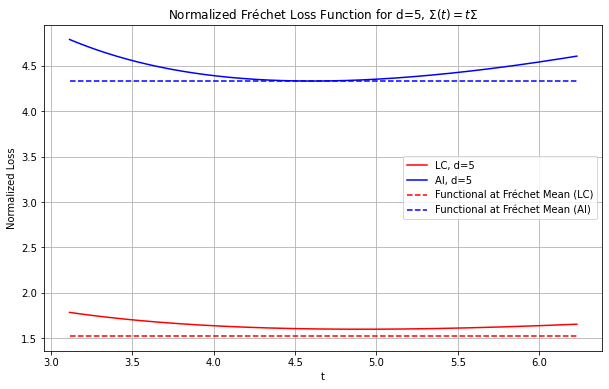

In [196]:
c1_array= np.linspace(3, 5, 600)
c2_array= np.linspace(2, 4, 600)
d2_array = [5]
c_id_q_2 = c1_array[:, None, None] * sigmas_q_2[1]
c_id_q_3 = c2_array[:, None, None] * sigmas_q_3[1]

c_simulate_frechet_loss(d_array = d2_array, Sigma_array = np.array([sigmas_q_2[1]]), matrices = c_id_q_2, n_samples = 10000)
c_simulate_frechet_loss(d_array = d2_array, Sigma_array = np.array([sigmas_q_3[1]]), matrices = c_id_q_3, n_samples = 10000)

 Scale matrix Sigma: [[ 0.22171292 -0.00828587]
 [-0.00828587  1.1558322 ]]
Simulating for d=7, q=2
Fréchet mean, LC:  [[ 1.33633653 -0.05193867]
 [-0.05193867  5.81727097]]
Fréchet mean, AI:  [[ 1.2210923  -0.04563477]
 [-0.04563477  6.36578957]]


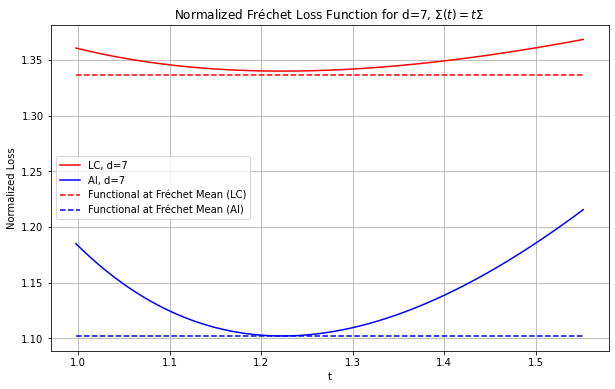

 Scale matrix Sigma: [[ 1.55760751  0.3378413   0.18304923]
 [ 0.3378413   0.14406073 -0.07245334]
 [ 0.18304923 -0.07245334  0.51273705]]
Simulating for d=7, q=3
Fréchet mean, LC:  [[ 9.38821159  2.11770374  1.14741461]
 [ 2.11770374  0.83391605 -0.33243895]
 [ 1.14741461 -0.33243895  2.38828617]]
Fréchet mean, AI:  [[ 7.7368713   1.67810869  0.90923314]
 [ 1.67810869  0.71557136 -0.35988666]
 [ 0.90923314 -0.35988666  2.54684222]]


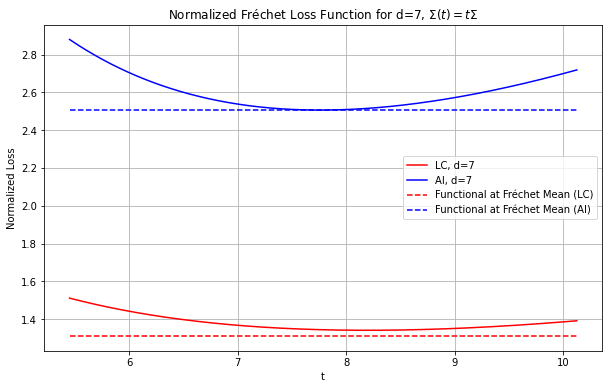

In [195]:
c1_array= np.linspace(4.5, 7, 600)
c2_array= np.linspace(3.5, 6.5, 600)
d3_array = [7]
c_id_q_2 = c1_array[:, None, None] * sigmas_q_2[1]
c_id_q_3 = c2_array[:, None, None] * sigmas_q_3[1]

c_simulate_frechet_loss(d_array = d3_array, Sigma_array = np.array([sigmas_q_2[1]]), matrices = c_id_q_2, n_samples = 10000)
c_simulate_frechet_loss(d_array = d3_array, Sigma_array = np.array([sigmas_q_3[1]]), matrices = c_id_q_3, n_samples = 10000)

In [235]:
#Check the interpolation is correct
print("S1:\n", extrinsic_mean(Sigma, d=10))
print("S2:\n", frechet_mean_ai(Sigma, d=10))
print("S3:\n", frechet_mean_lc(Sigma, d=10))

interp = interpolation_matrices(extrinsic_mean(Sigma, d=10), frechet_mean_ai(Sigma, d=10), frechet_mean_lc(Sigma, d=10), extrinsic_mean(Sigma, d=10))
print("S1:\n", interp[0])
print("S2:\n", interp[99])
print("S3:\n", interp[199])
print("S1:\n", interp[299])

S1:
 [[ 8.89477235 11.74437122  2.30902772]
 [11.74437122 18.61640407  2.95339039]
 [ 2.30902772  2.95339039  0.61370154]]
S2:
 [[ 7.09739563  9.37117282  1.84243987]
 [ 9.37117282 14.8545662   2.35659545]
 [ 1.84243987  2.35659545  0.48969017]]
S3:
 [[ 8.02164477 10.87813857  2.13872016]
 [10.87813857 17.24585398  2.82149707]
 [ 2.13872016  2.82149707  0.5806971 ]]
S1:
 [[ 8.89477235 11.74437122  2.30902772]
 [11.74437122 18.61640407  2.95339039]
 [ 2.30902772  2.95339039  0.61370154]]
S2:
 [[ 7.09739563  9.37117282  1.84243987]
 [ 9.37117282 14.8545662   2.35659545]
 [ 1.84243987  2.35659545  0.48969017]]
S3:
 [[ 8.02164477 10.87813857  2.13872016]
 [10.87813857 17.24585398  2.82149707]
 [ 2.13872016  2.82149707  0.5806971 ]]
S1:
 [[ 8.89477235 11.74437122  2.30902772]
 [11.74437122 18.61640407  2.95339039]
 [ 2.30902772  2.95339039  0.61370154]]
